# Multi-Dataset ImageNet Training with ResNet50 - Modular Version

This notebook demonstrates training ResNet50 on multiple ImageNet variants using a modular approach. The code supports experiments across different datasets for comprehensive analysis.

## Supported Datasets:
- **ImageNette**: 10 classes, 224x224 images (fastest for experiments)
- **Tiny ImageNet**: 200 classes, 64x64 images (medium complexity)
- **ImageNet Mini**: 1000 classes, 224x224 images (subset of full ImageNet)
- **Full ImageNet**: 1000 classes, 224x224 images (full dataset)

## Features:
- **Modular Design**: Separate modules for configuration, data loading, models, and training utilities
- **Multi-Dataset Support**: Easy switching between different ImageNet variants
- **Dataset-Specific Training**: Optimized hyperparameters for each dataset
- **Comprehensive Metrics**: Tracks training and validation metrics
- **Model Saving**: Automatic model checkpointing with dataset-specific naming


In [1]:
# 1️⃣ Mount Google Drive
from google.colab import drive
import os
drive.mount('/content/gdrive')

# 2️⃣ Define your Drive path (folder + file)
drive_folder = '/content/gdrive/My Drive/models'
os.makedirs(drive_folder, exist_ok=True)
file_path = os.path.join(drive_folder, 'dummy_direct_save.txt')

# 3️⃣ Write directly to Google Drive
with open(file_path, 'w') as f:
    f.write("✅ This file was written directly to Google Drive.\n")

print(f"📂 File written directly to: {file_path}")

# 4️⃣ Verify it exists
!ls -lh "/content/gdrive/My Drive/models"

Mounted at /content/gdrive
📂 File written directly to: /content/gdrive/My Drive/models/dummy_direct_save.txt
total 182M
-rw------- 1 root root  91M Oct 28 00:36 best_model_imagenette.pth
-rw------- 1 root root  92M Oct 28 19:20 best_model_tiny_imagenet.pth
-rw------- 1 root root   52 Oct 28 20:13 dummy_direct_save.txt
drwx------ 2 root root 4.0K Oct 28 00:42 imagenette_stage_1
drwx------ 2 root root 4.0K Oct 28 19:20 tiny_imagenet_stage_1


In [2]:
# Install required packages
%pip install torchsummary albumentations


In [3]:
# Step 1: Clone the repo
!rmdir ERAv4S9
!git clone https://github.com/nitin-vig/ERAv4S9.git

# Step 2: Move into the repo folder
%cd ERAv4S9

# Step 3: (Optional) List files to verify
!ls -l

rmdir: failed to remove 'ERAv4S9': No such file or directory
Cloning into 'ERAv4S9'...
remote: Enumerating objects: 229, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 229 (delta 9), reused 16 (delta 7), pack-reused 209 (from 1)
Receiving objects: 100% (229/229), 5.66 MiB | 10.59 MiB/s, done.
Resolving deltas: 100% (124/124), done.
/content/ERAv4S9
total 404
-rw-r--r-- 1 root root  13141 Oct 28 20:13 config.py
-rw-r--r-- 1 root root  25818 Oct 28 20:13 dataset_loader.py
-rw-r--r-- 1 root root 290094 Oct 28 20:13 ImageNet_Experiment_Resnet_50.ipynb
-rw-r--r-- 1 root root   8512 Oct 28 20:13 lr_finder.py
-rw-r--r-- 1 root root   7820 Oct 28 20:13 models.py
-rw-r--r-- 1 root root   4365 Oct 28 20:13 NOTEBOOK_MULTI_STAGE_GUIDE.md
-rw-r--r-- 1 root root   5715 Oct 28 20:13 progressive_transfer_learning_example.py
-rw-r--r-- 1 root root  10776 Oct 28 20:13 README.md
-rw-r--r-- 1 root root    695 Oct 28 20:13 requirements.txt

In [4]:
# Import all necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import drive

# Import our modular components
from config import Config
from dataset_loader import get_data_loaders, visualize_samples
from models import get_model, count_parameters, get_model_summary, save_model
from training_utils import train_model, train_model_with_transfer, evaluate_model, MetricsTracker, verify_saved_files

print(Config.__dict__)

print("All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


{'__module__': 'config', '__doc__': 'Configuration class for progressive training strategy', 'DEVICE': 'cpu', 'DATA_ROOT': '/content/data', 'SAVE_DIR': './progressive_models', 'SAVE_MODEL_PATH': '/content/gdrive/My Drive/models', 'MODEL_NAME': 'resnet50', 'MOUNT_DRIVE': True, 'DRIVE_MODEL_PATH': '/content/gdrive/My Drive/models', 'STAGES': {'imagenette': {'dataset': 'imagenette', 'classes': 10, 'image_size': 224, 'epochs': 20, 'batch_size': 256, 'lr': 0.001, 'optimizer': 'adamw', 'scheduler': 'cosine', 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'description': 'Quick warmup and architecture validation', 'enabled': True, 'priority': 1}, 'tiny_imagenet': {'dataset': 'tiny_imagenet', 'classes': 200, 'image_size': 64, 'epochs': 50, 'batch_size': 256, 'lr': 0.037, 'optimizer': 'sgd', 'scheduler': 'one_cycle', 'weight_decay': 0.001, 'label_smoothing': 0.1, 'mixup_alpha': 0.3, 'description': 'LR: 0.10 (safe max_lr for transfer learning with pretrained weights)', 'enabled': True, 'priority

## Configuration

Let's configure our training parameters. You can easily switch between datasets and modify training parameters here.


In [5]:
# Configuration setup for multi-dataset experiments
# You can easily switch between datasets by changing DATASET_NAME

# Dataset configuration
DATASET_NAME = "tiny_imagenet"  # Options: "imagenette", "tiny_imagenet", "imagenet_mini", "imagenet"
USE_PRETRAINED = False  # Custom implementation without pretrained weights

# Update configuration for the selected dataset
Config.update_for_dataset(DATASET_NAME)

print("Configuration updated!")
print(f"Dataset: {DATASET_NAME}")
print(f"Image size: {Config.IMAGE_SIZE}")
print(f"Number of classes: {Config.NUM_CLASSES}")
print(f"Batch size: {Config.BATCH_SIZE}")
print(f"Epochs: {Config.NUM_EPOCHS}")
print(f"Learning rate: {Config.LEARNING_RATE}")
print(f"Use pretrained: {USE_PRETRAINED}")

# Display dataset-specific training parameters
dataset_config = Config.get_dataset_config(DATASET_NAME)
print(f"\nDataset-specific parameters:")
print(f"Optimizer: {dataset_config['optimizer']}")
print(f"Scheduler: {dataset_config['scheduler']}")


Configuration updated for tiny_imagenet
Image size: 64
Number of classes: 200
Batch size: 256
Epochs: 50
Learning rate: 0.037
Configuration updated!
Dataset: tiny_imagenet
Image size: 64
Number of classes: 200
Batch size: 256
Epochs: 50
Learning rate: 0.037
Use pretrained: False

Dataset-specific parameters:
Optimizer: sgd
Scheduler: one_cycle


## Environment Setup

Setup the environment and check GPU availability. For full ImageNet training, you'll need significant computational resources.


In [6]:
# Setup environment
def setup_environment():
    """Setup environment for ImageNet training"""
    print("Setting up environment for ImageNet training...")

    # Create necessary directories
    os.makedirs(Config.DATA_ROOT, exist_ok=True)
    os.makedirs(Config.SAVE_MODEL_PATH, exist_ok=True)

    print("Environment setup complete!")

def check_gpu_availability():
    """Check GPU availability and setup device"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
        print("Warning: Full ImageNet training requires significant GPU memory!")
    else:
        print("Warning: CPU training will be very slow for ImageNet!")

    return device

# Run setup
setup_environment()
device = check_gpu_availability()

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)


Setting up environment for ImageNet training...
Environment setup complete!
Using device: cuda
GPU: Tesla T4
GPU Memory: 15.8 GB


In [7]:
# 🧩 Colab Dataset Setup Cell
# Copy-paste this cell into your Colab notebook

import os
import subprocess

# Install required packages (if not already installed)
!pip install -q torch torchvision albumentations tqdm requests

DATA_DIR = "/content/data"
IMAGENETTE_DIR = os.path.join(DATA_DIR, "imagenette2")
TINY_IMAGENET_DIR = os.path.join(DATA_DIR, "tiny-imagenet-200")

os.makedirs(DATA_DIR, exist_ok=True)

def run_cmd(cmd):
    """Helper to run shell commands cleanly."""
    result = subprocess.run(cmd, shell=True, check=False, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if result.returncode != 0:
        print(f"⚠️ Warning: {cmd} failed with error:\n{result.stderr}")
    return result

# ------------------------------
# 🔹 Download ImageNette
# # ------------------------------
# if not os.path.exists(IMAGENETTE_DIR) or len(os.listdir(IMAGENETTE_DIR)) == 0:
#     print("🔄 Downloading ImageNette...")
#     run_cmd("wget -q https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz")
#     run_cmd("tar -xzf imagenette2.tgz")
#     run_cmd(f"mv imagenette2 {DATA_DIR}/")
#     run_cmd("rm imagenette2.tgz")
#     print("✅ ImageNette downloaded!")
# else:
#     print(f"✅ Skipping ImageNette — already exists at {IMAGENETTE_DIR}")

# ------------------------------
# 🔹 Download Tiny ImageNet
# ------------------------------
if not os.path.exists(TINY_IMAGENET_DIR) or len(os.listdir(TINY_IMAGENET_DIR)) == 0:
    print("🔄 Downloading Tiny ImageNet...")
    run_cmd("wget -q http://cs231n.stanford.edu/tiny-imagenet-200.zip")
    run_cmd("unzip -q tiny-imagenet-200.zip")
    run_cmd(f"mv tiny-imagenet-200 {DATA_DIR}/")
    run_cmd("rm tiny-imagenet-200.zip")
    print("✅ Tiny ImageNet downloaded!")
else:
    print(f"✅ Skipping Tiny ImageNet — already exists at {TINY_IMAGENET_DIR}")

# ------------------------------
# 🔹 Verify
# ------------------------------
print("\n📁 Dataset verification:")
!ls -la {DATA_DIR}
!du -sh {DATA_DIR}/* | sort -h

print("\n🎉 Datasets ready! You can now use:")
print("from dataloader import get_data_loaders")
print("train_loader, test_loader = get_data_loaders('imagenette')")


🔄 Downloading Tiny ImageNet...
✅ Tiny ImageNet downloaded!

📁 Dataset verification:
total 12
drwxr-xr-x 3 root root 4096 Oct 28 20:14 .
drwxr-xr-x 1 root root 4096 Oct 28 20:13 ..
drwxrwxr-x 5 root root 4096 Feb  9  2015 tiny-imagenet-200
481M	/content/data/tiny-imagenet-200

🎉 Datasets ready! You can now use:
from dataloader import get_data_loaders
train_loader, test_loader = get_data_loaders('imagenette')


## Data Loading

Load the dataset and visualize some sample images.


Loading dataset...
📊 Tiny ImageNet Dataset Info:
   Total classes: 200
   Label range: 0 to 199
   First 5 classes: ['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640']
   Last 5 classes: ['n09246464', 'n09256479', 'n09332890', 'n09428293', 'n12267677']


/content/ERAv4S9/dataset_loader.py:481: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(
/content/ERAv4S9/dataset_loader.py:490: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.25),


   Labels in dataset: 0 to 199 (expected: 0 to 199)
   ✅ Labels are in correct range
📊 Tiny ImageNet Dataset Info:
   Total classes: 200
   Label range: 0 to 199
   First 5 classes: ['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640']
   Last 5 classes: ['n09246464', 'n09256479', 'n09332890', 'n09428293', 'n12267677']
   Labels in dataset: 0 to 199 (expected: 0 to 199)
   ✅ Labels are in correct range
Dataset: tiny_imagenet
Train samples: 100000
Test samples: 10000
Batch size: 256
Number of classes: 200

Visualizing sample images...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


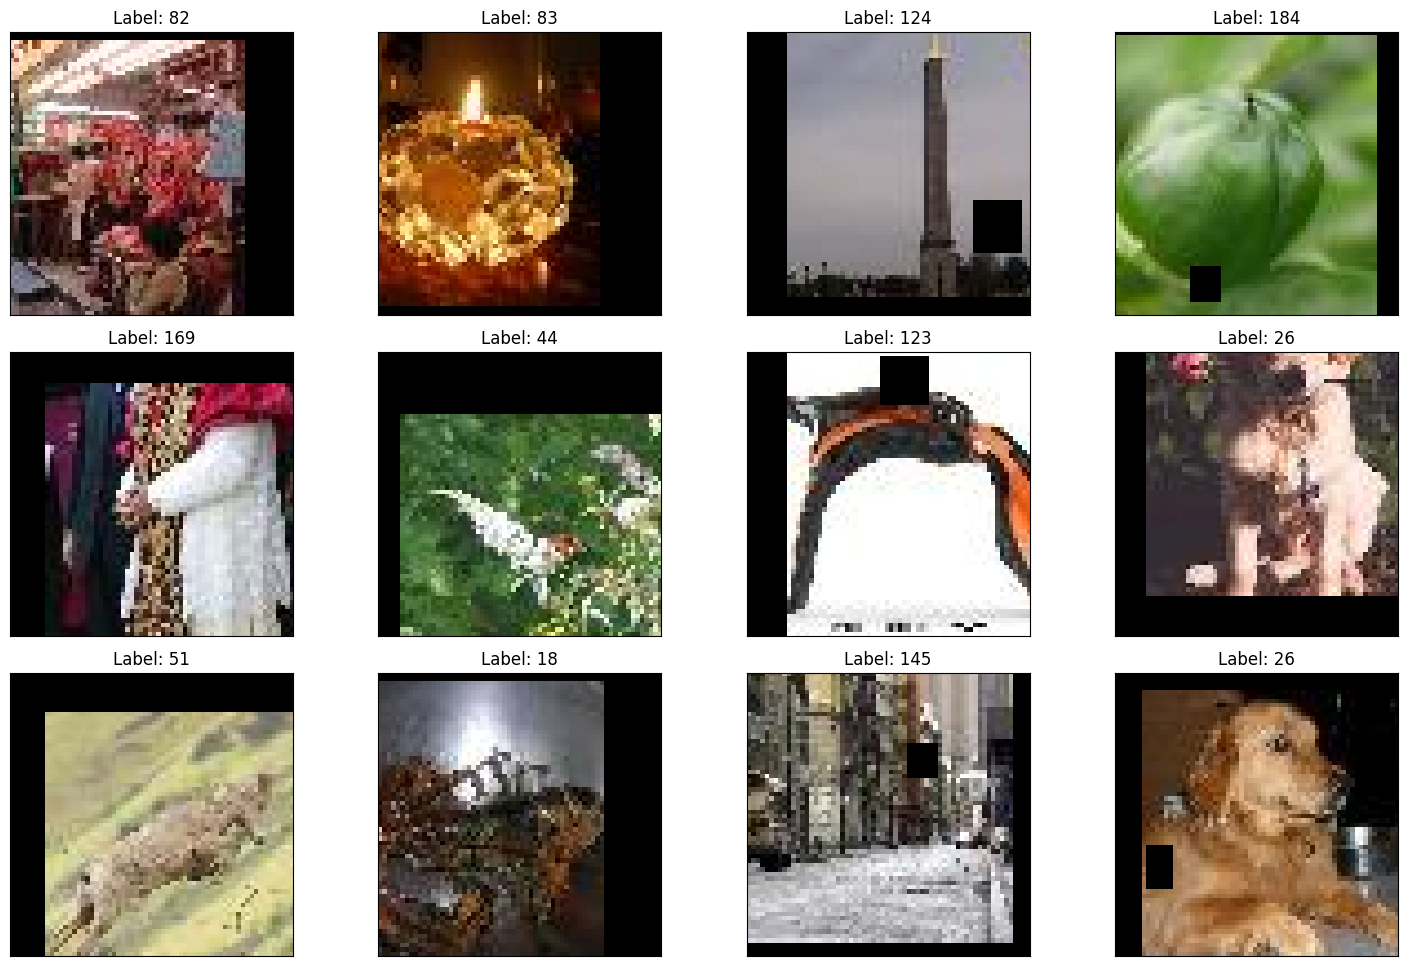

In [8]:
# Load dataset
print("Loading dataset...")
train_loader, test_loader = get_data_loaders(DATASET_NAME)

# Visualize some samples
print("\nVisualizing sample images...")
visualize_samples(train_loader, num_samples=12)


## Model Creation

Create the ResNet50 model and display its architecture.


In [9]:
# # Create model
# print(f"Creating {Config.MODEL_NAME} model...")
# model = get_model(
#     model_name=Config.MODEL_NAME,
#     dataset_name=DATASET_NAME,
#     pretrained=USE_PRETRAINED
# )

# # Move model to device
# model = model.to(device)

# # Print model info
# print(f"Model parameters: {count_parameters(model):,}")

# # Get model summary
# dataset_config = Config.get_dataset_config(DATASET_NAME)
# input_size = (3, dataset_config["image_size"], dataset_config["image_size"])
# print(f"\nModel summary (input size: {input_size}):")
# get_model_summary(model, input_size=input_size)


In [10]:
# Install pytorch-lr-finder if needed
!pip install torch-lr-finder

# Import and run LR finder
from lr_finder import run_lr_finder

# Find optimal LR for Tiny ImageNet (or any stage)
# STAGE_NAME = "tiny_imagenet"
# optimal_lr = run_lr_finder_for_stage(STAGE_NAME, num_iter=200)

# print(f"\n✅ Update config.py:")
# print(f"   'lr': {optimal_lr:.6f}")

## Training

Train the model using our modular training utilities.


## Progressive Transfer Learning (Multi-Stage Training)

Run multiple stages in sequence with automatic weight transfer from each stage to the next.


🚀 Progressive Transfer Learning Training
Stages to run: ['tiny_imagenet']
Start with pretrained: True
Save at each stage: True

📁 Models will be saved to: /content/gdrive/My Drive/models
   (Directory exists)
✅ Google Drive is mounted at: /content/gdrive

STAGE 1/1: TINY_IMAGENET
Configuration updated for tiny_imagenet
Image size: 64
Number of classes: 200
Batch size: 256
Epochs: 50
Learning rate: 0.037
Classes: 200
Image size: 64
Epochs: 50
Batch size: 256
LR: 0.037
Previous weights: /content/gdrive/My Drive/models/weights_for_tiny_imagenet.pth

📦 Loading tiny_imagenet dataset...
📊 Tiny ImageNet Dataset Info:
   Total classes: 200
   Label range: 0 to 199
   First 5 classes: ['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640']
   Last 5 classes: ['n09246464', 'n09256479', 'n09332890', 'n09428293', 'n12267677']
   Labels in dataset: 0 to 199 (expected: 0 to 199)
   ✅ Labels are in correct range
📊 Tiny ImageNet Dataset Info:
   Total classes: 200
   Label range: 0 to 199
  

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()

📊 LR Finder Results:
   📉 Minimum loss: 5.1998 at LR=0.100000
   📊 Suggested loss: 5.6679 at LR=0.045729
   ✅ Suggested max_lr: 0.045729
   📈 LR range: 1.00e-07 → 1.00e-01
   📍 Suggested LR position: 91/200 (45.5% through range)

📊 Plotting LR finder results...
LR suggestion: steepest gradient
Suggested LR: 4.27E-02


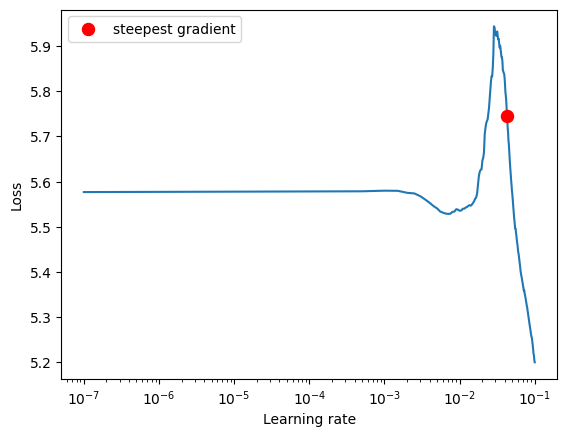

<Figure size 640x480 with 0 Axes>


💡 For One Cycle LR scheduler, use:
   max_lr = 0.045729
   This gives you:
   - Initial LR: 0.001829 (warmup starts, div_factor=25)
   - Peak LR: 0.045729 (at 30% through training)
   - Final LR: 0.000000183 (end of training, final_div_factor=10000)

✅ Recommended max_lr for One Cycle LR: 0.045729
💡 Update config.py with: 'lr': 0.045729

✅ Update config.py:
   'lr': 0.045729

🏋️ Training tiny_imagenet...
🔧 Optimizer: sgd, Max LR: 0.037, Scheduler: one_cycle

Epoch 1/50


Epoch 1 - Loss=5.2983 - Acc=1.08% - LR=0.001868: 100%|██████████| 391/391 [01:54<00:00,  3.41it/s]


Test set: Average loss: 5.1888, Top-1 Accuracy: 194/10000 (1.94%), Top-5 Accuracy: 808/10000 (8.08%)
New best model saved with test loss: 5.1888
Current learning rate: 0.001868

Epoch 2/50


Epoch 2 - Loss=5.1315 - Acc=2.23% - LR=0.003016: 100%|██████████| 391/391 [01:54<00:00,  3.43it/s]


Test set: Average loss: 5.0645, Top-1 Accuracy: 319/10000 (3.19%), Top-5 Accuracy: 1105/10000 (11.05%)
New best model saved with test loss: 5.0645
Current learning rate: 0.003016

Epoch 3/50


Epoch 3 - Loss=4.9960 - Acc=3.48% - LR=0.004873: 100%|██████████| 391/391 [01:54<00:00,  3.43it/s]


Test set: Average loss: 4.8978, Top-1 Accuracy: 440/10000 (4.40%), Top-5 Accuracy: 1546/10000 (15.46%)
New best model saved with test loss: 4.8978
Current learning rate: 0.004873

Epoch 4/50


Epoch 4 - Loss=4.8120 - Acc=5.41% - LR=0.007358: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s]


Test set: Average loss: 4.6982, Top-1 Accuracy: 664/10000 (6.64%), Top-5 Accuracy: 2121/10000 (21.21%)
New best model saved with test loss: 4.6982
Current learning rate: 0.007358

Epoch 5/50


Epoch 5 - Loss=4.6493 - Acc=7.65% - LR=0.010363: 100%|██████████| 391/391 [01:53<00:00,  3.43it/s]


Test set: Average loss: 4.5397, Top-1 Accuracy: 883/10000 (8.83%), Top-5 Accuracy: 2605/10000 (26.05%)
New best model saved with test loss: 4.5397
Current learning rate: 0.010363

Epoch 6/50


Epoch 6 - Loss=4.4750 - Acc=9.99% - LR=0.013755: 100%|██████████| 391/391 [01:53<00:00,  3.44it/s]


Test set: Average loss: 4.3679, Top-1 Accuracy: 1169/10000 (11.69%), Top-5 Accuracy: 3156/10000 (31.56%)
New best model saved with test loss: 4.3679
Current learning rate: 0.013755

Epoch 7/50


Epoch 7 - Loss=4.2904 - Acc=13.04% - LR=0.017388: 100%|██████████| 391/391 [01:54<00:00,  3.41it/s]


Test set: Average loss: 4.2498, Top-1 Accuracy: 1384/10000 (13.84%), Top-5 Accuracy: 3503/10000 (35.03%)
New best model saved with test loss: 4.2498
Current learning rate: 0.017388

Epoch 8/50


Epoch 8 - Loss=4.1202 - Acc=16.02% - LR=0.021101: 100%|██████████| 391/391 [01:53<00:00,  3.44it/s]


Test set: Average loss: 4.0966, Top-1 Accuracy: 1642/10000 (16.42%), Top-5 Accuracy: 4009/10000 (40.09%)
New best model saved with test loss: 4.0966
Current learning rate: 0.021101

Epoch 9/50


Epoch 9 - Loss=4.0034 - Acc=17.94% - LR=0.024734: 100%|██████████| 391/391 [01:53<00:00,  3.43it/s]


Test set: Average loss: 3.9014, Top-1 Accuracy: 2046/10000 (20.46%), Top-5 Accuracy: 4578/10000 (45.78%)
New best model saved with test loss: 3.9014
Current learning rate: 0.024734

Epoch 10/50


Epoch 10 - Loss=3.8745 - Acc=20.66% - LR=0.028125: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s]


Test set: Average loss: 3.8503, Top-1 Accuracy: 2165/10000 (21.65%), Top-5 Accuracy: 4712/10000 (47.12%)
New best model saved with test loss: 3.8503
Current learning rate: 0.028125

Epoch 11/50


Epoch 11 - Loss=3.7965 - Acc=22.18% - LR=0.031129: 100%|██████████| 391/391 [01:53<00:00,  3.44it/s]


Test set: Average loss: 3.7866, Top-1 Accuracy: 2311/10000 (23.11%), Top-5 Accuracy: 4971/10000 (49.71%)
New best model saved with test loss: 3.7866
Current learning rate: 0.031129

Epoch 12/50


Epoch 12 - Loss=3.7029 - Acc=24.28% - LR=0.033613: 100%|██████████| 391/391 [01:53<00:00,  3.43it/s]


Test set: Average loss: 3.7282, Top-1 Accuracy: 2345/10000 (23.45%), Top-5 Accuracy: 5030/10000 (50.30%)
New best model saved with test loss: 3.7282
Current learning rate: 0.033613

Epoch 13/50


Epoch 13 - Loss=3.6137 - Acc=26.01% - LR=0.035468: 100%|██████████| 391/391 [01:53<00:00,  3.44it/s]


Test set: Average loss: 5.4144, Top-1 Accuracy: 2026/10000 (20.26%), Top-5 Accuracy: 4273/10000 (42.73%)
Current learning rate: 0.035468

Epoch 14/50


Epoch 14 - Loss=3.5612 - Acc=27.35% - LR=0.036614: 100%|██████████| 391/391 [01:53<00:00,  3.44it/s]


Test set: Average loss: 3.5989, Top-1 Accuracy: 2704/10000 (27.04%), Top-5 Accuracy: 5411/10000 (54.11%)
New best model saved with test loss: 3.5989
Current learning rate: 0.036614

Epoch 15/50


Epoch 15 - Loss=3.4812 - Acc=28.91% - LR=0.037000: 100%|██████████| 391/391 [01:53<00:00,  3.44it/s]


Test set: Average loss: 3.4819, Top-1 Accuracy: 2937/10000 (29.37%), Top-5 Accuracy: 5630/10000 (56.30%)
New best model saved with test loss: 3.4819
Current learning rate: 0.037000

Epoch 16/50


Epoch 16 - Loss=3.4153 - Acc=30.38% - LR=0.036925: 100%|██████████| 391/391 [01:53<00:00,  3.44it/s]


Test set: Average loss: 3.8254, Top-1 Accuracy: 2467/10000 (24.67%), Top-5 Accuracy: 5064/10000 (50.64%)
Current learning rate: 0.036925

Epoch 17/50


Epoch 17 - Loss=3.3673 - Acc=31.61% - LR=0.036702: 100%|██████████| 391/391 [01:53<00:00,  3.44it/s]


Test set: Average loss: 3.3788, Top-1 Accuracy: 3237/10000 (32.37%), Top-5 Accuracy: 5870/10000 (58.70%)
New best model saved with test loss: 3.3788
Current learning rate: 0.036702

Epoch 18/50


Epoch 18 - Loss=3.2998 - Acc=33.01% - LR=0.036332: 100%|██████████| 391/391 [01:53<00:00,  3.43it/s]


Test set: Average loss: 3.3285, Top-1 Accuracy: 3246/10000 (32.46%), Top-5 Accuracy: 6072/10000 (60.72%)
New best model saved with test loss: 3.3285
Current learning rate: 0.036332

Epoch 19/50


Epoch 19 - Loss=3.2498 - Acc=34.23% - LR=0.035819: 100%|██████████| 391/391 [01:54<00:00,  3.43it/s]


Test set: Average loss: 3.3692, Top-1 Accuracy: 3145/10000 (31.45%), Top-5 Accuracy: 5956/10000 (59.56%)
Current learning rate: 0.035819

Epoch 20/50


Epoch 20 - Loss=3.2073 - Acc=35.21% - LR=0.035166: 100%|██████████| 391/391 [01:53<00:00,  3.44it/s]


Test set: Average loss: 3.4197, Top-1 Accuracy: 3144/10000 (31.44%), Top-5 Accuracy: 5865/10000 (58.65%)
Current learning rate: 0.035166

Epoch 21/50


Epoch 21 - Loss=3.1695 - Acc=36.15% - LR=0.034379: 100%|██████████| 391/391 [01:53<00:00,  3.43it/s]


Test set: Average loss: 3.4599, Top-1 Accuracy: 3026/10000 (30.26%), Top-5 Accuracy: 5734/10000 (57.34%)
Current learning rate: 0.034379

Epoch 22/50


Epoch 22 - Loss=3.1369 - Acc=36.83% - LR=0.033464: 100%|██████████| 391/391 [01:54<00:00,  3.43it/s]


Test set: Average loss: 3.2194, Top-1 Accuracy: 3498/10000 (34.98%), Top-5 Accuracy: 6364/10000 (63.64%)
New best model saved with test loss: 3.2194
Current learning rate: 0.033464

Epoch 23/50


Epoch 23 - Loss=3.0906 - Acc=37.89% - LR=0.032429: 100%|██████████| 391/391 [01:53<00:00,  3.43it/s]


Test set: Average loss: 3.3419, Top-1 Accuracy: 3240/10000 (32.40%), Top-5 Accuracy: 6037/10000 (60.37%)
Current learning rate: 0.032429

Epoch 24/50


Epoch 24 - Loss=3.0579 - Acc=38.67% - LR=0.031282: 100%|██████████| 391/391 [01:53<00:00,  3.44it/s]


Test set: Average loss: 3.2622, Top-1 Accuracy: 3439/10000 (34.39%), Top-5 Accuracy: 6215/10000 (62.15%)
Current learning rate: 0.031282

Epoch 25/50


Epoch 25 - Loss=3.0244 - Acc=39.51% - LR=0.030031: 100%|██████████| 391/391 [01:53<00:00,  3.44it/s]


Test set: Average loss: 3.2123, Top-1 Accuracy: 3552/10000 (35.52%), Top-5 Accuracy: 6336/10000 (63.36%)
New best model saved with test loss: 3.2123
Current learning rate: 0.030031

Epoch 26/50


Epoch 26 - Loss=2.9887 - Acc=40.51% - LR=0.028688: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s]


Test set: Average loss: 3.0747, Top-1 Accuracy: 3840/10000 (38.40%), Top-5 Accuracy: 6656/10000 (66.56%)
New best model saved with test loss: 3.0747
Current learning rate: 0.028688

Epoch 27/50


Epoch 27 - Loss=2.9547 - Acc=41.24% - LR=0.027263: 100%|██████████| 391/391 [01:53<00:00,  3.45it/s]


Test set: Average loss: 3.0140, Top-1 Accuracy: 4044/10000 (40.44%), Top-5 Accuracy: 6848/10000 (68.48%)
New best model saved with test loss: 3.0140
Current learning rate: 0.027263

Epoch 28/50


Epoch 28 - Loss=2.9261 - Acc=41.85% - LR=0.025767: 100%|██████████| 391/391 [01:53<00:00,  3.44it/s]


Test set: Average loss: 3.1696, Top-1 Accuracy: 3695/10000 (36.95%), Top-5 Accuracy: 6408/10000 (64.08%)
Current learning rate: 0.025767

Epoch 29/50


Epoch 29 - Loss=2.8982 - Acc=42.53% - LR=0.024213: 100%|██████████| 391/391 [01:53<00:00,  3.43it/s]


Test set: Average loss: 3.0605, Top-1 Accuracy: 3908/10000 (39.08%), Top-5 Accuracy: 6641/10000 (66.41%)
Current learning rate: 0.024213

Epoch 30/50


Epoch 30 - Loss=2.8655 - Acc=43.29% - LR=0.022613: 100%|██████████| 391/391 [01:53<00:00,  3.44it/s]


Test set: Average loss: 3.0143, Top-1 Accuracy: 4013/10000 (40.13%), Top-5 Accuracy: 6784/10000 (67.84%)
Current learning rate: 0.022613

Epoch 31/50


Epoch 31 - Loss=2.8331 - Acc=44.25% - LR=0.020979: 100%|██████████| 391/391 [01:53<00:00,  3.45it/s]


Test set: Average loss: 2.9682, Top-1 Accuracy: 4124/10000 (41.24%), Top-5 Accuracy: 6897/10000 (68.97%)
New best model saved with test loss: 2.9682
Current learning rate: 0.020979

Epoch 32/50


Epoch 32 - Loss=2.8009 - Acc=45.03% - LR=0.019326: 100%|██████████| 391/391 [01:53<00:00,  3.43it/s]


Test set: Average loss: 3.0391, Top-1 Accuracy: 4024/10000 (40.24%), Top-5 Accuracy: 6700/10000 (67.00%)
Current learning rate: 0.019326

Epoch 33/50


Epoch 33 - Loss=2.7686 - Acc=45.73% - LR=0.017666: 100%|██████████| 391/391 [01:53<00:00,  3.46it/s]


Test set: Average loss: 2.9181, Top-1 Accuracy: 4297/10000 (42.97%), Top-5 Accuracy: 6956/10000 (69.56%)
New best model saved with test loss: 2.9181
Current learning rate: 0.017666

Epoch 34/50


Epoch 34 - Loss=2.7265 - Acc=46.87% - LR=0.016013: 100%|██████████| 391/391 [01:53<00:00,  3.45it/s]


Test set: Average loss: 2.8641, Top-1 Accuracy: 4407/10000 (44.07%), Top-5 Accuracy: 7113/10000 (71.13%)
New best model saved with test loss: 2.8641
Current learning rate: 0.016013

Epoch 35/50


Epoch 35 - Loss=2.6957 - Acc=47.57% - LR=0.014379: 100%|██████████| 391/391 [01:53<00:00,  3.43it/s]


Test set: Average loss: 2.8488, Top-1 Accuracy: 4447/10000 (44.47%), Top-5 Accuracy: 7113/10000 (71.13%)
New best model saved with test loss: 2.8488
Current learning rate: 0.014379

Epoch 36/50


Epoch 36 - Loss=2.6455 - Acc=49.03% - LR=0.012779: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s]


Test set: Average loss: 2.8172, Top-1 Accuracy: 4519/10000 (45.19%), Top-5 Accuracy: 7188/10000 (71.88%)
New best model saved with test loss: 2.8172
Current learning rate: 0.012779

Epoch 37/50


Epoch 37 - Loss=2.6047 - Acc=50.04% - LR=0.011225: 100%|██████████| 391/391 [01:53<00:00,  3.45it/s]


Test set: Average loss: 2.8021, Top-1 Accuracy: 4604/10000 (46.04%), Top-5 Accuracy: 7221/10000 (72.21%)
New best model saved with test loss: 2.8021
Current learning rate: 0.011225

Epoch 38/50


Epoch 38 - Loss=2.5512 - Acc=51.37% - LR=0.009730: 100%|██████████| 391/391 [01:53<00:00,  3.44it/s]


Test set: Average loss: 2.7741, Top-1 Accuracy: 4648/10000 (46.48%), Top-5 Accuracy: 7322/10000 (73.22%)
New best model saved with test loss: 2.7741
Current learning rate: 0.009730

Epoch 39/50


Epoch 39 - Loss=2.5029 - Acc=52.75% - LR=0.008305: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s]


Test set: Average loss: 2.7124, Top-1 Accuracy: 4772/10000 (47.72%), Top-5 Accuracy: 7472/10000 (74.72%)
New best model saved with test loss: 2.7124
Current learning rate: 0.008305

Epoch 40/50


Epoch 40 - Loss=2.4430 - Acc=54.36% - LR=0.006962: 100%|██████████| 391/391 [01:53<00:00,  3.44it/s]


Test set: Average loss: 2.7275, Top-1 Accuracy: 4781/10000 (47.81%), Top-5 Accuracy: 7423/10000 (74.23%)
Current learning rate: 0.006962

Epoch 41/50


Epoch 41 - Loss=2.3713 - Acc=56.22% - LR=0.005712: 100%|██████████| 391/391 [01:53<00:00,  3.46it/s]


Test set: Average loss: 2.6441, Top-1 Accuracy: 4984/10000 (49.84%), Top-5 Accuracy: 7589/10000 (75.89%)
New best model saved with test loss: 2.6441
Current learning rate: 0.005712

Epoch 42/50


Epoch 42 - Loss=2.2990 - Acc=58.33% - LR=0.004566: 100%|██████████| 391/391 [01:53<00:00,  3.44it/s]


Test set: Average loss: 2.5960, Top-1 Accuracy: 5124/10000 (51.24%), Top-5 Accuracy: 7648/10000 (76.48%)
New best model saved with test loss: 2.5960
Current learning rate: 0.004566

Epoch 43/50


Epoch 43 - Loss=2.2154 - Acc=60.47% - LR=0.003531: 100%|██████████| 391/391 [01:53<00:00,  3.43it/s]


Test set: Average loss: 2.5610, Top-1 Accuracy: 5217/10000 (52.17%), Top-5 Accuracy: 7719/10000 (77.19%)
New best model saved with test loss: 2.5610
Current learning rate: 0.003531

Epoch 44/50


Epoch 44 - Loss=2.1278 - Acc=63.02% - LR=0.002617: 100%|██████████| 391/391 [01:53<00:00,  3.45it/s]


Test set: Average loss: 2.5210, Top-1 Accuracy: 5352/10000 (53.52%), Top-5 Accuracy: 7797/10000 (77.97%)
New best model saved with test loss: 2.5210
Current learning rate: 0.002617

Epoch 45/50


Epoch 45 - Loss=2.0337 - Acc=65.87% - LR=0.001830: 100%|██████████| 391/391 [01:53<00:00,  3.44it/s]


Test set: Average loss: 2.4705, Top-1 Accuracy: 5468/10000 (54.68%), Top-5 Accuracy: 7886/10000 (78.86%)
New best model saved with test loss: 2.4705
Current learning rate: 0.001830

Epoch 46/50


Epoch 46 - Loss=1.9425 - Acc=68.43% - LR=0.001178: 100%|██████████| 391/391 [01:53<00:00,  3.43it/s]


Test set: Average loss: 2.4281, Top-1 Accuracy: 5632/10000 (56.32%), Top-5 Accuracy: 7979/10000 (79.79%)
New best model saved with test loss: 2.4281
Current learning rate: 0.001178

Epoch 47/50


Epoch 47 - Loss=1.8525 - Acc=71.36% - LR=0.000666: 100%|██████████| 391/391 [01:53<00:00,  3.45it/s]


Test set: Average loss: 2.4127, Top-1 Accuracy: 5646/10000 (56.46%), Top-5 Accuracy: 7982/10000 (79.82%)
New best model saved with test loss: 2.4127
Current learning rate: 0.000666

Epoch 48/50


Epoch 48 - Loss=1.7853 - Acc=73.44% - LR=0.000297: 100%|██████████| 391/391 [01:53<00:00,  3.43it/s]


Test set: Average loss: 2.3980, Top-1 Accuracy: 5703/10000 (57.03%), Top-5 Accuracy: 8031/10000 (80.31%)
New best model saved with test loss: 2.3980
Current learning rate: 0.000297

Epoch 49/50


Epoch 49 - Loss=1.7366 - Acc=75.02% - LR=0.000074: 100%|██████████| 391/391 [01:53<00:00,  3.44it/s]


Test set: Average loss: 2.3885, Top-1 Accuracy: 5758/10000 (57.58%), Top-5 Accuracy: 8050/10000 (80.50%)
New best model saved with test loss: 2.3885
Current learning rate: 0.000074

Epoch 50/50


Epoch 50 - Loss=1.7182 - Acc=75.64% - LR=0.000000: 100%|██████████| 391/391 [01:54<00:00,  3.43it/s]


Test set: Average loss: 2.3869, Top-1 Accuracy: 5745/10000 (57.45%), Top-5 Accuracy: 8035/10000 (80.35%)
New best model saved with test loss: 2.3869
Current learning rate: 0.000000
✅ Saved model: /content/gdrive/My Drive/models/tiny_imagenet_stage_1/final_model.pth
✅ Saved metrics: /content/gdrive/My Drive/models/tiny_imagenet_stage_1/metrics.json
✅ Metrics plot saved to /content/gdrive/My Drive/models/tiny_imagenet_stage_1/training_metrics.png
✅ Saved training graphs: /content/gdrive/My Drive/models/tiny_imagenet_stage_1/training_metrics.png
🧹 GPU memory cleared for next stage

✅ Stage 1 completed!
--------------------------------------------------------------------------------

🎉 ALL STAGES COMPLETE!

📊 Results Summary:
Stage                Test Accuracy   Model Path                                                  
-----------------------------------------------------------------------------------------------
tiny_imagenet        57.45           /content/gdrive/My Drive/models/tiny_

In [11]:
"""
PROGRESSIVE TRANSFER LEARNING - RUN SELECTED STAGES
===================================================
Train multiple stages in sequence with automatic weight transfer.
"""

import json
from datetime import datetime

# ⚙️ CONFIGURATION - Choose which stages to run
# ================================================
STAGES_TO_RUN = [ "tiny_imagenet"]  # Modify this list
# Options: "imagenette", "tiny_imagenet", "imagenet_mini", "imagenet"
# Order matters! Stages run in sequence with weight transfer

USE_PRETRAINED_FOR_FIRST_STAGE = True  # Start with ImageNet pretrained weights?
SAVE_RESULTS_AT_EACH_STAGE = True  # Save models and metrics at each stage?

# Results storage
all_stage_results = {}
pretrained_weights_path = "/content/gdrive/My Drive/models/weights_for_tiny_imagenet.pth"

# Verify save path exists (create if needed)
print("🚀 Progressive Transfer Learning Training")
print(f"Stages to run: {STAGES_TO_RUN}")
print(f"Start with pretrained: {USE_PRETRAINED_FOR_FIRST_STAGE}")
print(f"Save at each stage: {SAVE_RESULTS_AT_EACH_STAGE}")
print("="*80)

# Check if save path exists
save_path = Config.SAVE_MODEL_PATH
if not os.path.exists(save_path):
    print(f"\n⚠️ Save path doesn't exist: {save_path}")
    print(f"Creating directory...")
    os.makedirs(save_path, exist_ok=True)
    print(f"✅ Created: {save_path}")
else:
    print(f"\n📁 Models will be saved to: {save_path}")
    print(f"   (Directory exists)")

# Verify Google Drive is mounted (if using /gdrive)
if save_path.startswith('/content/gdrive'):
    gdrive_root = '/content/gdrive'
    if not os.path.exists(gdrive_root):
        print(f"\n❌ ERROR: Google Drive not mounted!")
        print(f"Please run the 'Mount Google Drive' cell (Cell 11) first.")
        print(f"After mounting, Google Drive will be available at: /content/gdrive")
    else:
        print(f"✅ Google Drive is mounted at: {gdrive_root}")

print("="*80)

for i, stage_name in enumerate(STAGES_TO_RUN, 1):
    print(f"\n{'='*80}")
    print(f"STAGE {i}/{len(STAGES_TO_RUN)}: {stage_name.upper()}")
    print(f"{'='*80}")

    # Update configuration for this stage
    Config.update_for_dataset(stage_name)

    # Get stage configuration
    stage_config = Config.STAGES[stage_name]
    print(f"Classes: {stage_config['classes']}")
    print(f"Image size: {stage_config['image_size']}")
    print(f"Epochs: {stage_config['epochs']}")
    print(f"Batch size: {stage_config['batch_size']}")
    print(f"LR: {stage_config['lr']}")
    print(f"Previous weights: {pretrained_weights_path or 'None (fresh start)'}")

    # Load dataset
    print(f"\n📦 Loading {stage_name} dataset...")
    train_loader, test_loader = get_data_loaders(stage_name)

    # Create model
    print(f"\n🧠 Creating model for {stage_name}...")
    use_pretrained = USE_PRETRAINED_FOR_FIRST_STAGE if (i == 1 and not pretrained_weights_path) else False
    model = get_model(
        model_name=Config.MODEL_NAME,
        dataset_name=stage_name,
        pretrained=use_pretrained
    )
    model = model.to(device)
    print(f"Model created: {count_parameters(model):,} parameters")
    # LR finder should run on the model with pretrained weights if using previous stages
    optimal_lr = run_lr_finder(model,stage_name ,num_iter=200)

    print(f"\n✅ Update config.py:")
    print(f"   'lr': {optimal_lr:.6f}")

    # Determine next stage name for weight saving
    next_stage = STAGES_TO_RUN[i] if i < len(STAGES_TO_RUN) else None

    # Train with transfer learning
    print(f"\n🏋️ Training {stage_name}...")
    metrics_tracker, final_weights = train_model_with_transfer(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        device=device,
        config=Config,
        pretrained_weights_path=pretrained_weights_path,
        next_stage_name=next_stage,
        dataset_name=stage_name
    )

    # Save results if requested
    if SAVE_RESULTS_AT_EACH_STAGE:
        stage_save_dir = f"{Config.SAVE_MODEL_PATH}/{stage_name}_stage_{i}"
        os.makedirs(stage_save_dir, exist_ok=True)

        # Save final model
        final_model_path = f"{stage_save_dir}/final_model.pth"
        torch.save(model.state_dict(), final_model_path)
        print(f"✅ Saved model: {final_model_path}")

        # Save metrics
        metrics_data = {
            "stage": stage_name,
            "stage_number": i,
            "final_train_loss": metrics_tracker.train_losses[-1] if metrics_tracker.train_losses else None,
            "final_train_acc": metrics_tracker.train_acc[-1] if metrics_tracker.train_acc else None,
            "final_test_loss": metrics_tracker.test_losses[-1] if metrics_tracker.test_losses else None,
            "final_test_acc": metrics_tracker.test_acc[-1] if metrics_tracker.test_acc else None,
            "config": stage_config
        }

        metrics_path = f"{stage_save_dir}/metrics.json"
        with open(metrics_path, 'w') as f:
            json.dump(metrics_data, f, indent=2)
        print(f"✅ Saved metrics: {metrics_path}")

        # Save metrics plot (graph with training curves)
        plot_path = f"{stage_save_dir}/training_metrics.png"
        metrics_tracker.plot_metrics(save_path=plot_path)
        print(f"✅ Saved training graphs: {plot_path}")

        all_stage_results[stage_name] = {
            "metrics": metrics_data,
            "model_path": final_model_path,
            "plot_path": plot_path
        }

        # Set weights path for next stage
    if next_stage:
        pretrained_weights_path = f"{Config.SAVE_MODEL_PATH}/weights_for_{next_stage}.pth"

    # Free GPU memory before moving to next stage
    if torch.cuda.is_available():
        del model  # Delete model to free memory
        del metrics_tracker  # Delete metrics tracker
        torch.cuda.empty_cache()  # Clear CUDA cache
        print("🧹 GPU memory cleared for next stage")

    print(f"\n✅ Stage {i} completed!")
    print("-"*80)

# Final summary
print("\n" + "="*80)
print("🎉 ALL STAGES COMPLETE!")
print("="*80)
if SAVE_RESULTS_AT_EACH_STAGE:
    print("\n📊 Results Summary:")
    print(f"{'Stage':<20} {'Test Accuracy':<15} {'Model Path':<60}")
    print("-"*95)
    for stage_name, result in all_stage_results.items():
        final_test_acc = result['metrics'].get('final_test_acc', 'N/A')
        model_path = result.get('model_path', 'N/A')
        if isinstance(final_test_acc, (int, float)):
            print(f"{stage_name:<20} {final_test_acc:<15.2f} {model_path}")
        else:
            print(f"{stage_name:<20} {str(final_test_acc):<15} {model_path}")

    print(f"\n{'='*80}")
    print(f"📁 Base Save Directory: {Config.SAVE_MODEL_PATH}")
    if Config.SAVE_MODEL_PATH.startswith('/gdrive'):
        print(f"📂 Location: Google Drive (My Drive/models)")
    print(f"\n📦 For each stage, you'll find:")
    print(f"  • final_model.pth - Trained model weights")
    print(f"  • metrics.json - Training metrics")
    print(f"  • training_metrics.png - Training curves graph")

    # Verify files were actually saved
    print(f"\n{'='*80}")
    print("🔍 Verifying saved files:")
    verify_saved_files(Config.SAVE_MODEL_PATH)


In [12]:

drive_model_path = f"{Config.DRIVE_MODEL_PATH}/final_model.pth"
save_model(model, drive_model_path, epoch=30, loss=0)
print(f"Model also saved to Google Drive: {drive_model_path}")


NameError: name 'model' is not defined